# Imports

In [1]:
from pathlib import Path

from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from imageio import imwrite


from geograypher.constants import MATPLOTLIB_PALLETE, VIS_FOLDER
from geograypher.utils.example_data import (
    create_non_overlapping_points,
    create_scene_mesh,
)
from geograypher.cameras.cameras import PhotogrammetryCameraSet
from geograypher.meshes.meshes import TexturedPhotogrammetryMesh
from geograypher.predictors.derived_segmentors import LookUpSegmentor
from geograypher.utils.visualization import show_segmentation_labels
from geograypher.cameras.segmentor import (
    SegmentorPhotogrammetryCameraSet,
)

# Config options

In [2]:
# Where to save content
CONCEPT_FIGURE_ROOT = Path(VIS_FOLDER, "concept_figure_content")
IMAGE_FOLDER = Path(CONCEPT_FIGURE_ROOT, "realistic_images")
FIGURES_SAVE_FOLDER = Path(CONCEPT_FIGURE_ROOT, "figures")
LABEL_IMAGES_FOLDER = Path(CONCEPT_FIGURE_ROOT, "labeled_images")

# Save vis or show them in the notebook
SAVE_VIS = True

# Number of map elements
N_BOXES = 5
N_CYLINDERS = 5
N_CONES = 5
# Random seed for object locations
MAP_RANDOM_SEED = 42 #1029
# Discritization of the ground plane
GROUND_RESOLUTION = 200
# Scale of the frustum
VIS_FRUSTUM_SCALE = 1

# Mapping from integer IDs to human-readable labels
IDS_TO_LABELS = {0: "cone", 1: "cube", 2: "cylinder"}

# Range of hues for each object
HUE_RANGE_DICT = {"cone": 0.1, "cylinder": 0.2, "cube": 0.1}
# Only used for realist
REALISTIC_COLOR_DICT = {
    "cone": MATPLOTLIB_PALLETE[0],
    "cylinder": MATPLOTLIB_PALLETE[2],
    "cube": MATPLOTLIB_PALLETE[1],
}

# Camera set params
CAM_HEIGHT = 10
CAM_DIST_FROM_CENTER = 10
CAM_PITCH = 225

CAM_INTRINSICS = {
    0: {"f": 4000, "cx": 0, "cy": 0, "image_width": 3000, "image_height": 2200}
}

# Create the example data

In [3]:
points = create_non_overlapping_points(
    n_points=(N_BOXES + N_CYLINDERS + N_CONES), random_seed=MAP_RANDOM_SEED
)

mesh, labels_gdf = create_scene_mesh(
    box_centers=points[:N_BOXES],
    cylinder_centers=points[N_BOXES : (N_BOXES + N_CYLINDERS)],
    cone_centers=points[(N_BOXES + N_CYLINDERS) : (N_BOXES + N_CYLINDERS + N_CONES)],
    add_ground=True,
    ground_resolution=GROUND_RESOLUTION,
)

# Define the colors for the "realistic" views

In [4]:
def make_color_gradient(color, number, hue_range=None):
    if hue_range is None:
        hue_range = 1 / (number * 2)

    hsv_color = matplotlib.colors.rgb_to_hsv(color)
    hue_start = hsv_color[0] - hue_range / 2
    hue_end = hsv_color[0] + hue_range / 2
    hues = np.linspace(hue_start, hue_end, number) % 1.0
    shifted_HSVs = [np.concatenate(([hue], hsv_color[1:]), axis=0) for hue in hues]
    rgb_values = [
        matplotlib.colors.hsv_to_rgb(shifted_hue) for shifted_hue in shifted_HSVs
    ]
    rgb_values = np.vstack(rgb_values)

    rgb_values = rgb_values / 255.0

    return rgb_values


colors_per_face = np.full((mesh.n_cells, 3), fill_value=0.5)
IDs_per_face = np.full((mesh.n_cells, 1), fill_value=np.nan)

for i, (name, group) in enumerate(labels_gdf.groupby("name")):
    num = len(group)
    gradient = make_color_gradient(
        REALISTIC_COLOR_DICT[name], num, hue_range=HUE_RANGE_DICT[name]
    )
    # Indices into the original dataset
    IDs = group.index.to_numpy()
    # TODO rename
    for ID, color in zip(IDs, gradient):
        matching = mesh["ID"] == ID
        colors_per_face[matching, :] = color
        IDs_per_face[matching, :] = i

# Show the 2D map

<Axes: >

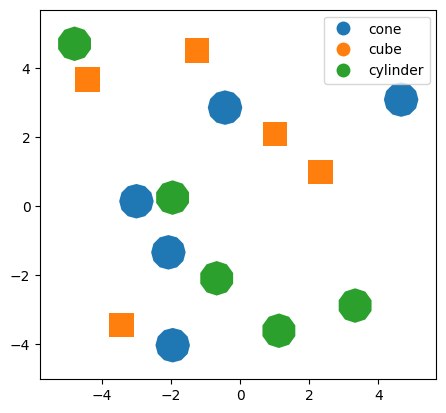

In [5]:
labels_gdf.plot("name", legend=True, cmap="tab10", vmin=0, vmax=9)

# Create a set of virtual cameras

In [6]:
# Create translations
t_vecs = (
    (0, 0, CAM_HEIGHT),
    (0, CAM_DIST_FROM_CENTER, CAM_HEIGHT),
    (CAM_DIST_FROM_CENTER, 0, CAM_HEIGHT),
    (-CAM_DIST_FROM_CENTER, 0, CAM_HEIGHT),
    (0, -CAM_DIST_FROM_CENTER, CAM_HEIGHT),
)
# Create rotations in roll, pitch, yaw convention
r_vecs = (
    (180, 180, 0),  # nadir
    (180, CAM_PITCH, 0),  # oblique
    (90, CAM_PITCH, 0),  # oblique
    (270, CAM_PITCH, 0),  # oblique
    (0, CAM_PITCH, 0),  # oblique
)

# Create 4x4 transforms
cam_to_world_transforms = []
for r_vec, t_vec in zip(r_vecs, t_vecs):
    r_mat = Rotation.from_euler("ZXY", r_vec, degrees=True).as_matrix()
    transform = np.eye(4)
    transform[:3, :3] = r_mat
    transform[:3, 3] = t_vec
    cam_to_world_transforms.append(transform)

IMAGE_FOLDER.mkdir(exist_ok=True, parents=True)
# Note that these files do not exist yet, but will be later created
image_filenames = [Path(IMAGE_FOLDER, f"img_{i:03d}.png") for i in range(5)]

camera_set = PhotogrammetryCameraSet(
    cam_to_world_transforms=cam_to_world_transforms,
    intrinsic_params_per_sensor_type=CAM_INTRINSICS,
    image_folder=IMAGE_FOLDER,
    image_filenames=image_filenames,
)

# Create a colored mesh with a "realistic" textuer

Loading mesh
Selecting an ROI from mesh
mesh CRS is None, reproject_CRS is doing nothing
Extracting faces from mesh
Loading texture


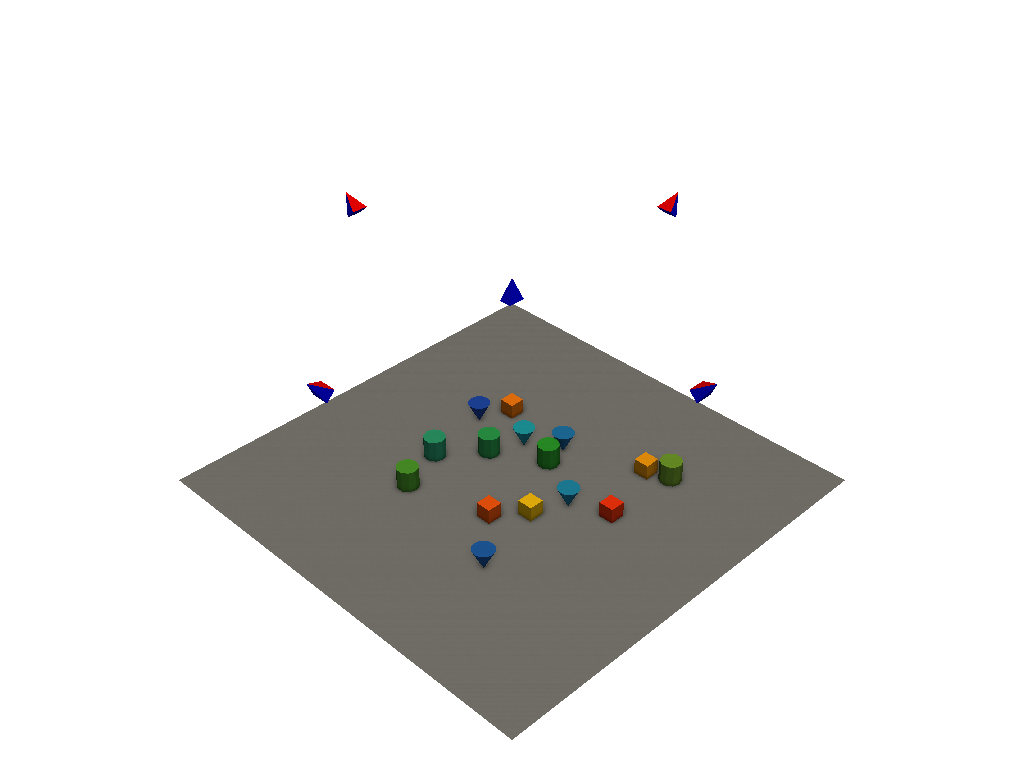

In [7]:
realistic_mesh = TexturedPhotogrammetryMesh(mesh, input_CRS=None, texture=colors_per_face)
realistic_mesh.vis(
    force_xvfb=True,
    camera_set=camera_set,
    screenshot_filename=Path(FIGURES_SAVE_FOLDER, "realistic_scene.png"),
    frustum_scale=VIS_FRUSTUM_SCALE,
)

# Create a mesh textured with the labels

Loading mesh
Selecting an ROI from mesh
mesh CRS is None, reproject_CRS is doing nothing
Extracting faces from mesh
Loading texture


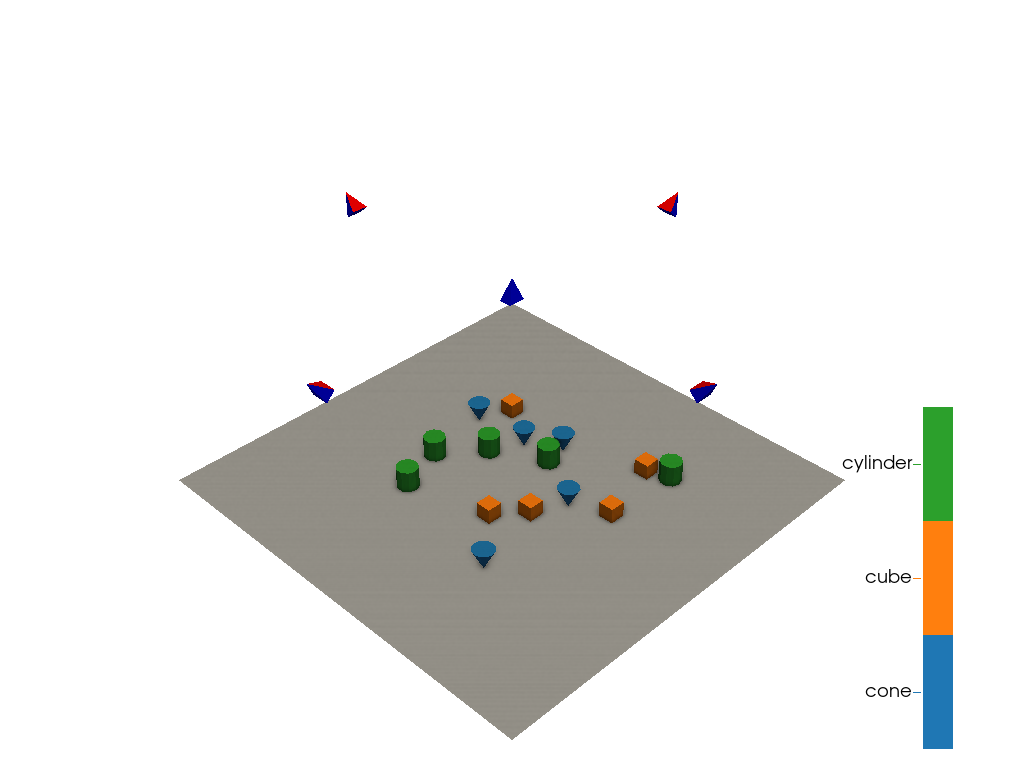

In [8]:
labeled_mesh = TexturedPhotogrammetryMesh(
    mesh,
    input_CRS=None,
    texture=IDs_per_face,
    IDs_to_labels=IDS_TO_LABELS,
)
labeled_mesh.vis(
    force_xvfb=True,
    camera_set=camera_set,
    screenshot_filename=Path(FIGURES_SAVE_FOLDER, "labeled_scene.png"),
    frustum_scale=VIS_FRUSTUM_SCALE,
)

# Render from the camera viewpoints

In [9]:
FIGURES_SAVE_FOLDER.mkdir(exist_ok=True, parents=True)
LABEL_IMAGES_FOLDER.mkdir(exist_ok=True, parents=True)

label_renders_gen = labeled_mesh.render_flat(camera_set)
flat_texture_render_gen = realistic_mesh.render_flat(camera_set)
realistic_render_gen = realistic_mesh.render_flat(camera_set)

for i, (label_render, flat_texture_render, realistic_render) in tqdm(
        enumerate(
            zip(label_renders_gen, flat_texture_render_gen, realistic_render_gen)
        ),
        total=5
    ):

    # Save out an integer label image
    label_render_for_saving = np.squeeze(label_render.copy())
    label_render_for_saving[np.logical_not(np.isfinite(label_render_for_saving))] = 255
    label_render_for_saving = label_render_for_saving.astype(np.uint8)

    imwrite(Path(LABEL_IMAGES_FOLDER, f"img_{i:03d}.png"), label_render_for_saving)
    # Save out the rendered "realistic imager"
    image_path = camera_set.get_image_filename(i, absolute=True)
    imwrite(image_path, (realistic_render*255).astype(np.uint8))

    # Save or vis the figures
    plt.axis("off")
    plt.tight_layout()
    plt.imshow(flat_texture_render)

    if SAVE_VIS:
        plt.savefig(Path(FIGURES_SAVE_FOLDER, f"texture_render_flat_{i:03d}.png"))
        plt.close()
    else:
        plt.show()

    plt.axis("off")
    plt.tight_layout()
    plt.imshow(
        label_render,
        cmap="tab10",
        vmin=0,
        vmax=9,
        interpolation="none",
    )
    if SAVE_VIS:
        plt.savefig(Path(FIGURES_SAVE_FOLDER, f"class_render_flat{i:03d}.png"))
        plt.close()
    else:
        plt.show()

    plt.axis("off")
    plt.tight_layout()
    plt.imshow(realistic_render)
    if SAVE_VIS:
        plt.savefig(Path(FIGURES_SAVE_FOLDER, f"texture_render_realistic_{i:03d}.png"))
        plt.close()
    else:
        plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:22<00:00,  4.50s/it]


# Show rendered labels

Showing segmentation labels:   0%|          | 0/5 [00:00<?, ?it/s]

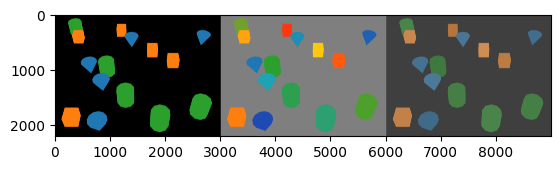

Showing segmentation labels:  20%|██        | 1/5 [00:02<00:09,  2.30s/it]

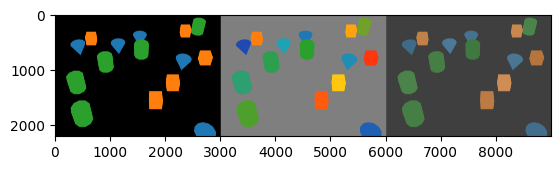

Showing segmentation labels:  40%|████      | 2/5 [00:04<00:06,  2.30s/it]

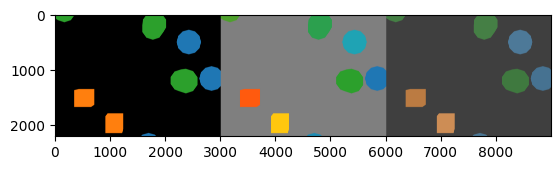

Showing segmentation labels:  60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

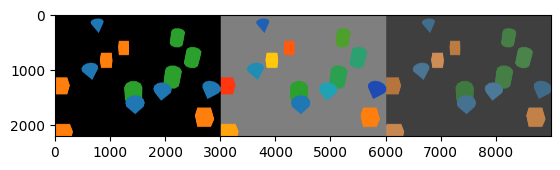

Showing segmentation labels:  80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

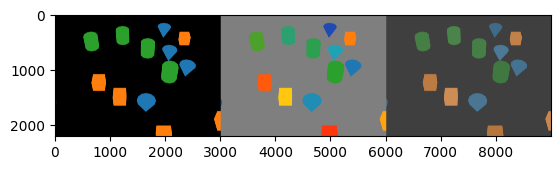

Showing segmentation labels: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


In [10]:
show_segmentation_labels(
    label_folder=LABEL_IMAGES_FOLDER,
    image_folder=IMAGE_FOLDER,
    num_show=5,
    image_suffix=".png",
    IDs_to_labels=IDS_TO_LABELS
)

# Create a segmentor that looks up labeled images

In [11]:
segmentor = LookUpSegmentor(IMAGE_FOLDER, LABEL_IMAGES_FOLDER, num_classes=3)
segmentor_camera_set = SegmentorPhotogrammetryCameraSet(camera_set, segmentor)
aggregation_mesh = TexturedPhotogrammetryMesh(mesh=mesh, input_CRS=None, IDs_to_labels=IDS_TO_LABELS)

Loading mesh
Selecting an ROI from mesh
mesh CRS is None, reproject_CRS is doing nothing
Extracting faces from mesh
Loading texture


# Show which faces were projected onto at all

  0%|          | 0/5 [00:00<?, ?it/s]

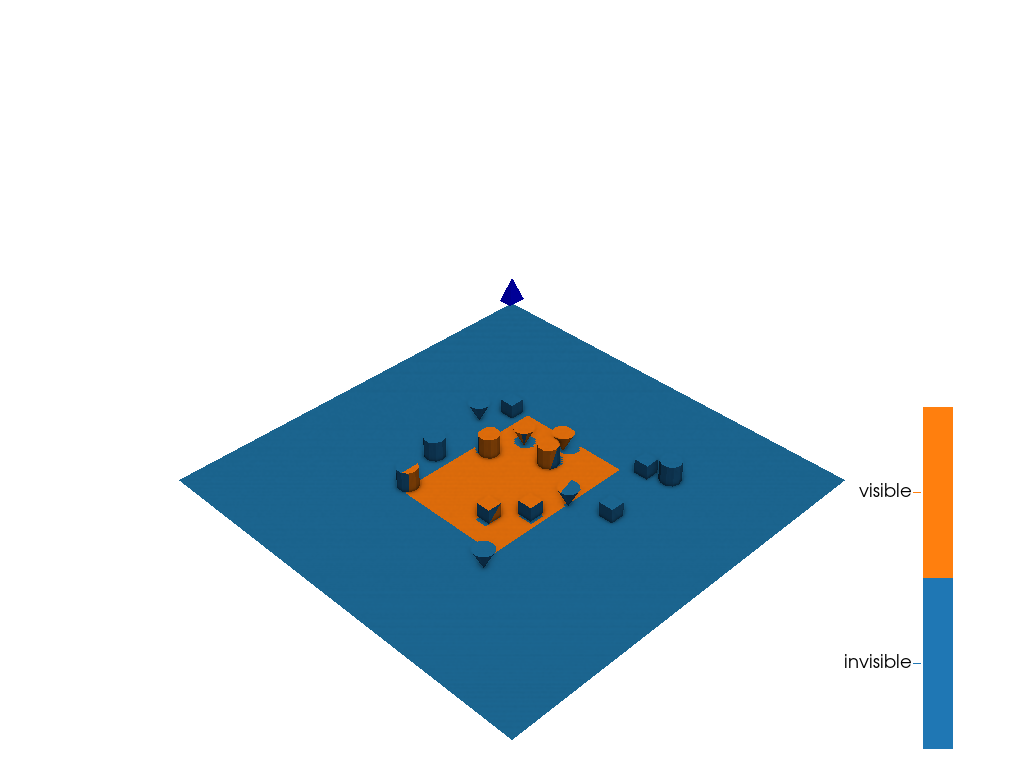

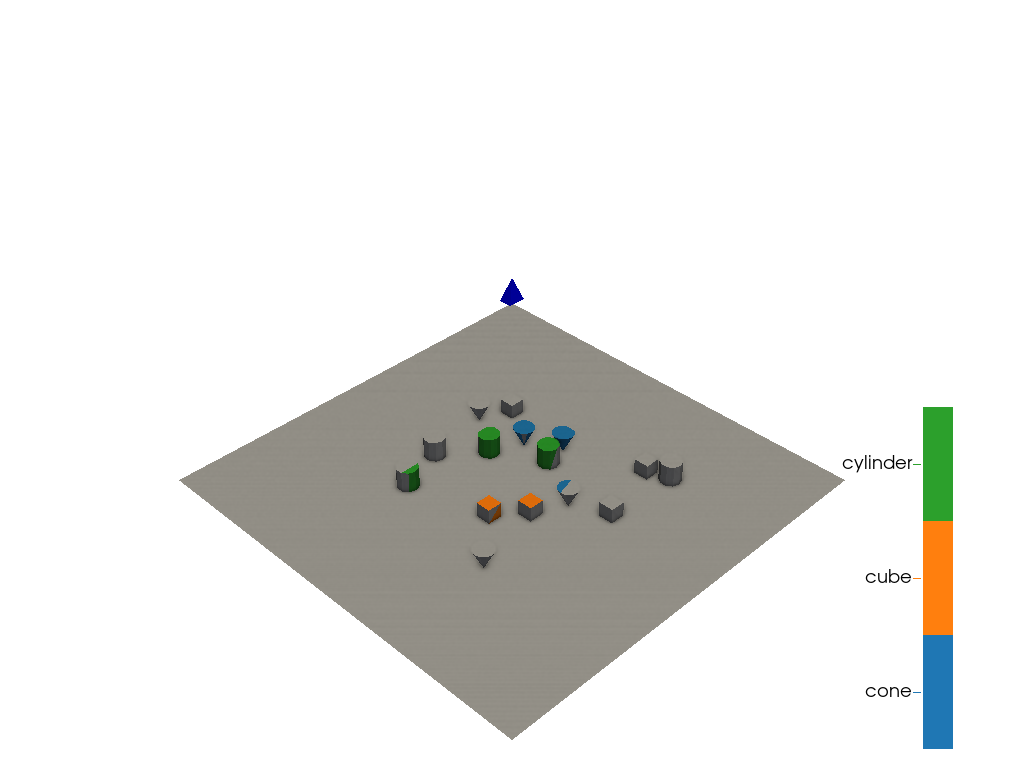

 20%|██        | 1/5 [00:04<00:17,  4.29s/it]

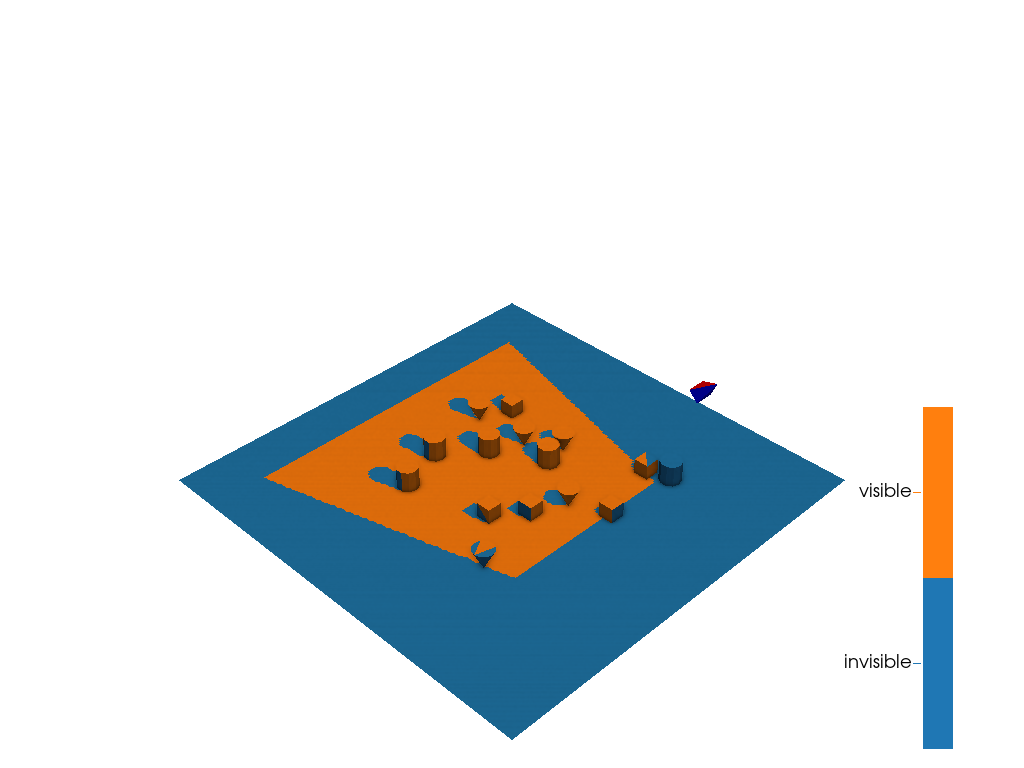

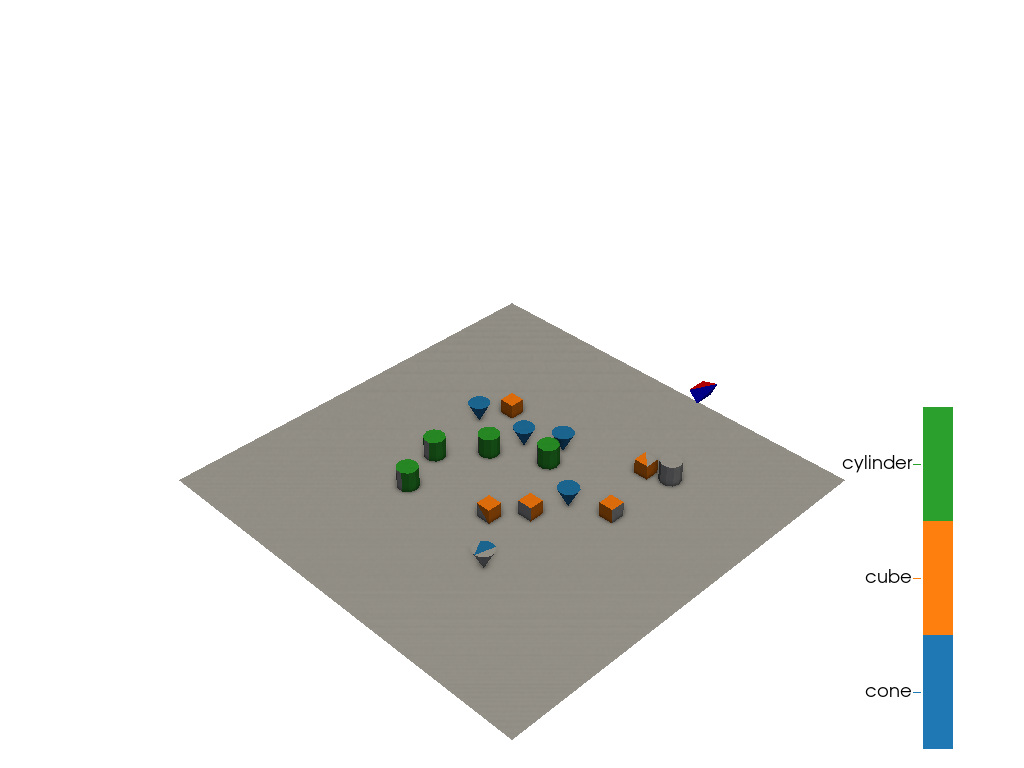

 40%|████      | 2/5 [00:08<00:12,  4.32s/it]

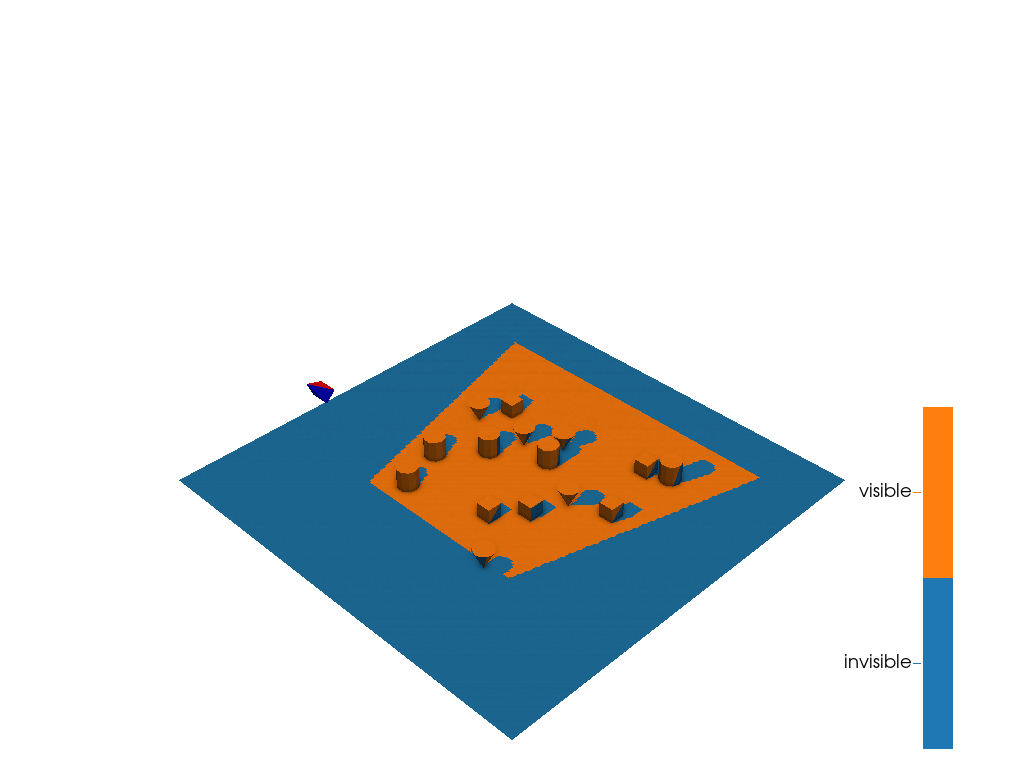

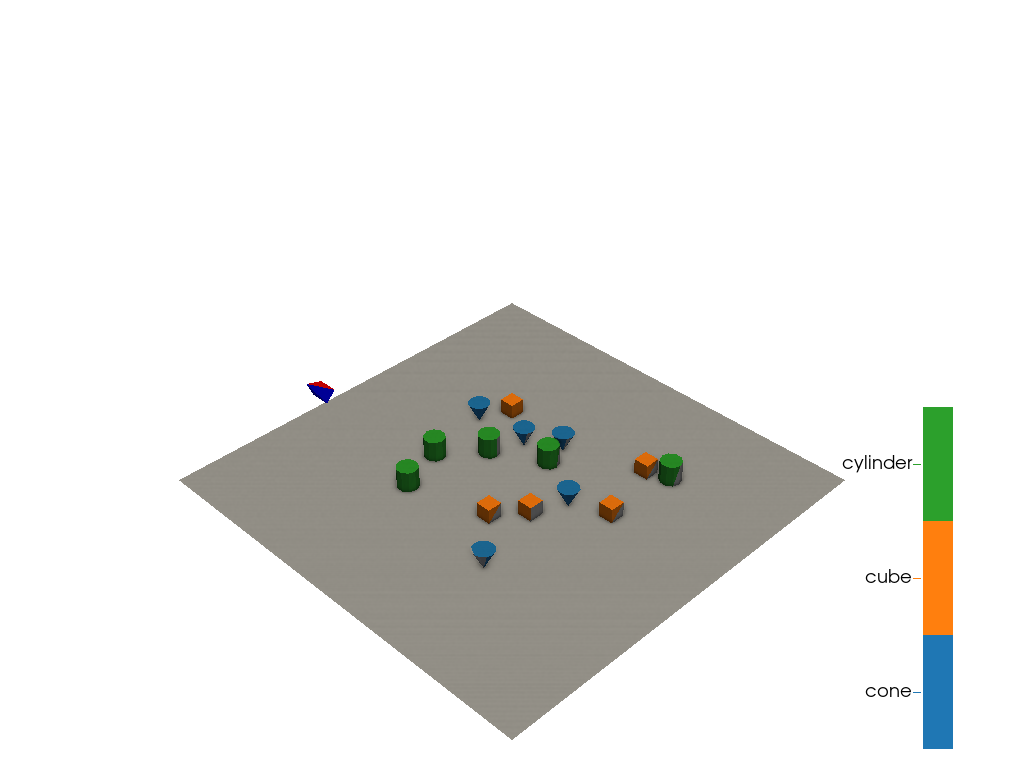

 60%|██████    | 3/5 [00:13<00:08,  4.38s/it]

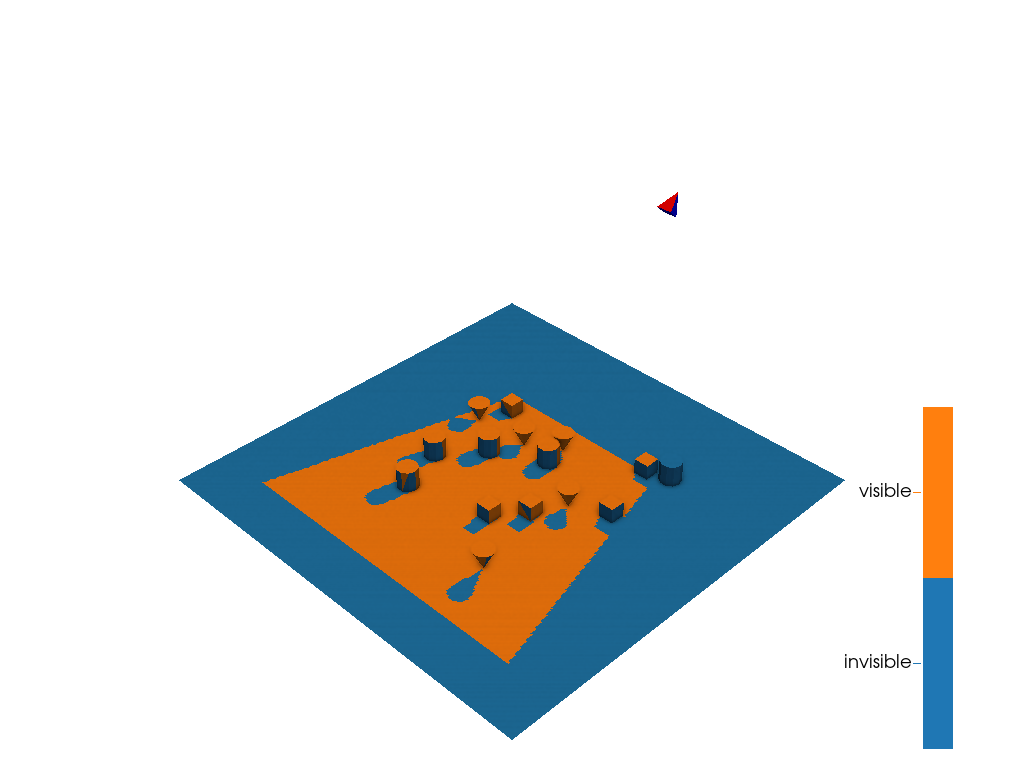

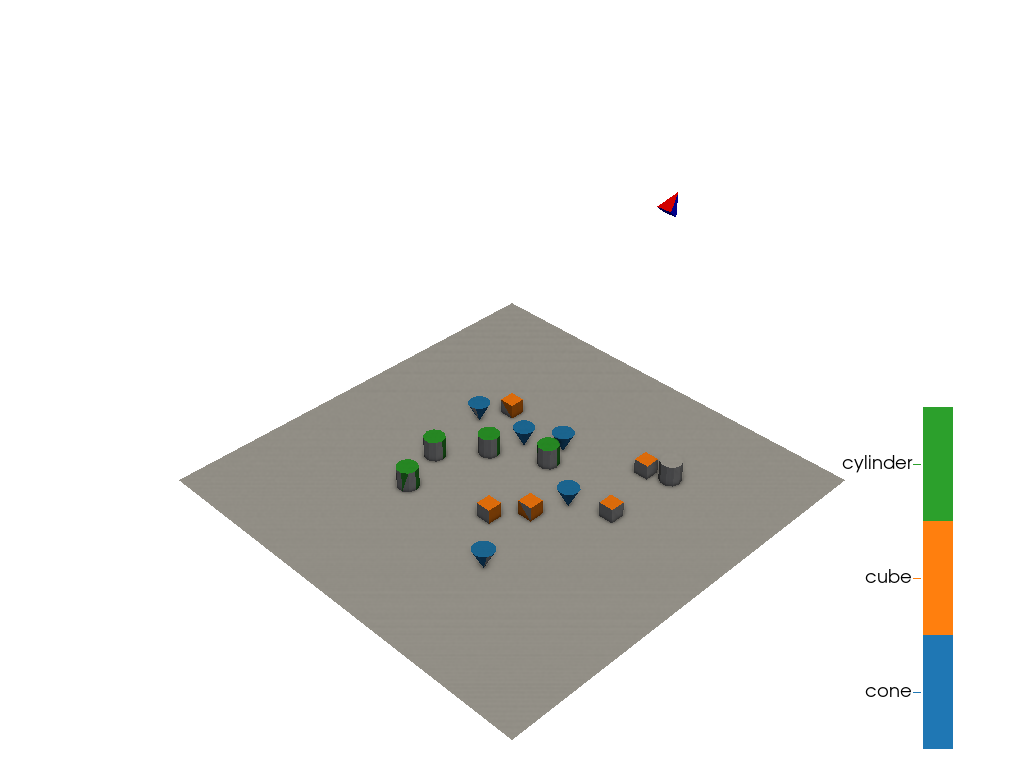

 80%|████████  | 4/5 [00:17<00:04,  4.39s/it]

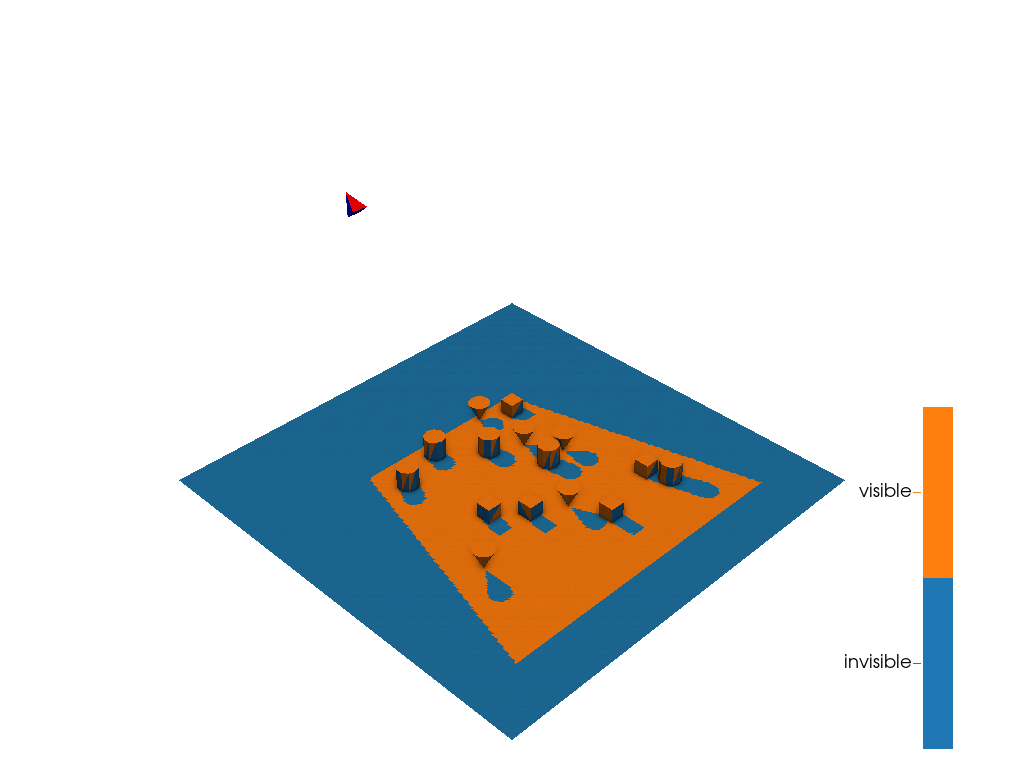

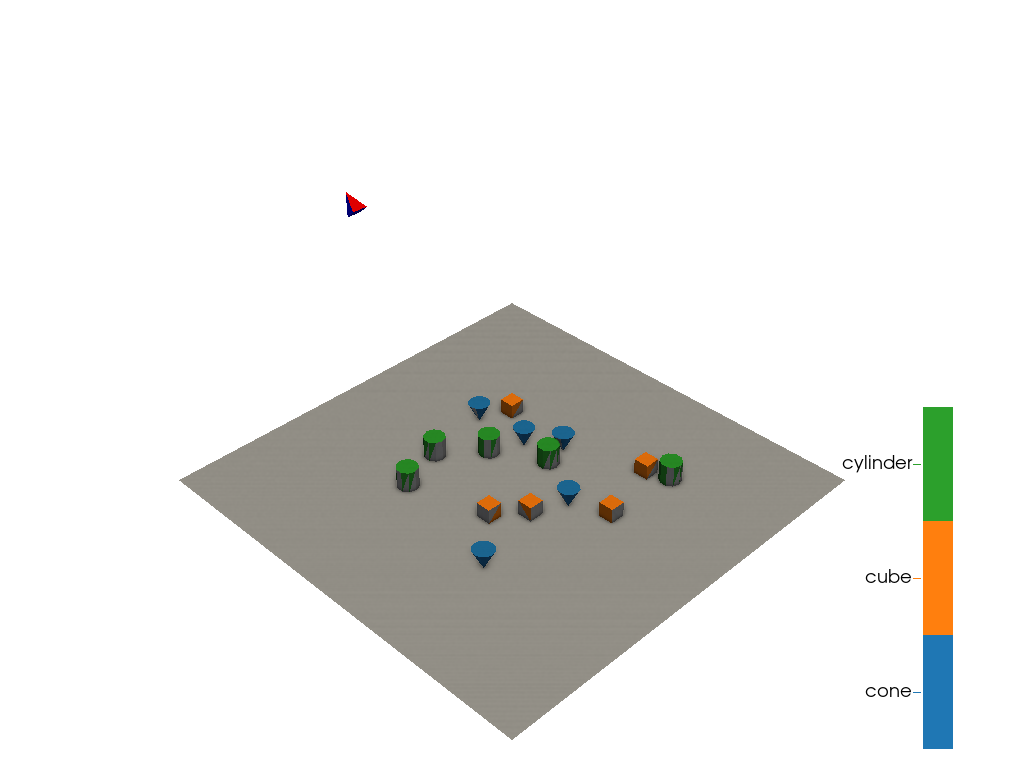

100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


In [12]:
projections_gen = aggregation_mesh.project_images(segmentor_camera_set)

for i, faces_texture in tqdm(enumerate(projections_gen), total=5):
    is_finite = np.any(np.isfinite(faces_texture), axis=1)

    aggregation_mesh.vis(
        vis_scalars=is_finite.astype(int),
        camera_set=segmentor_camera_set.get_subset_cameras([i]),
        screenshot_filename=Path(
            FIGURES_SAVE_FOLDER, f"view_shadows_scene_{i:03d}.png"
        ),
        frustum_scale=VIS_FRUSTUM_SCALE,
        IDs_to_labels={0: "invisible", 1: "visible"},
    )

    max_class = np.argmax(faces_texture, axis=1).astype(float)
    max_class[np.logical_not(is_finite)] = np.nan
    max_class[np.sum(faces_texture, axis=1)==0] = np.nan
    segmentor_camera_set.get_subset_cameras([i])
    aggregation_mesh.vis(
        vis_scalars=max_class,
        camera_set=segmentor_camera_set.get_subset_cameras([i]),
        force_xvfb=True,
        screenshot_filename=Path(
            FIGURES_SAVE_FOLDER, f"aggregated_predicted_scene_{i:03d}.png"
        ),
        frustum_scale=VIS_FRUSTUM_SCALE,
    )

# Show aggregated viewpoint

Aggregating projected viewpoints: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


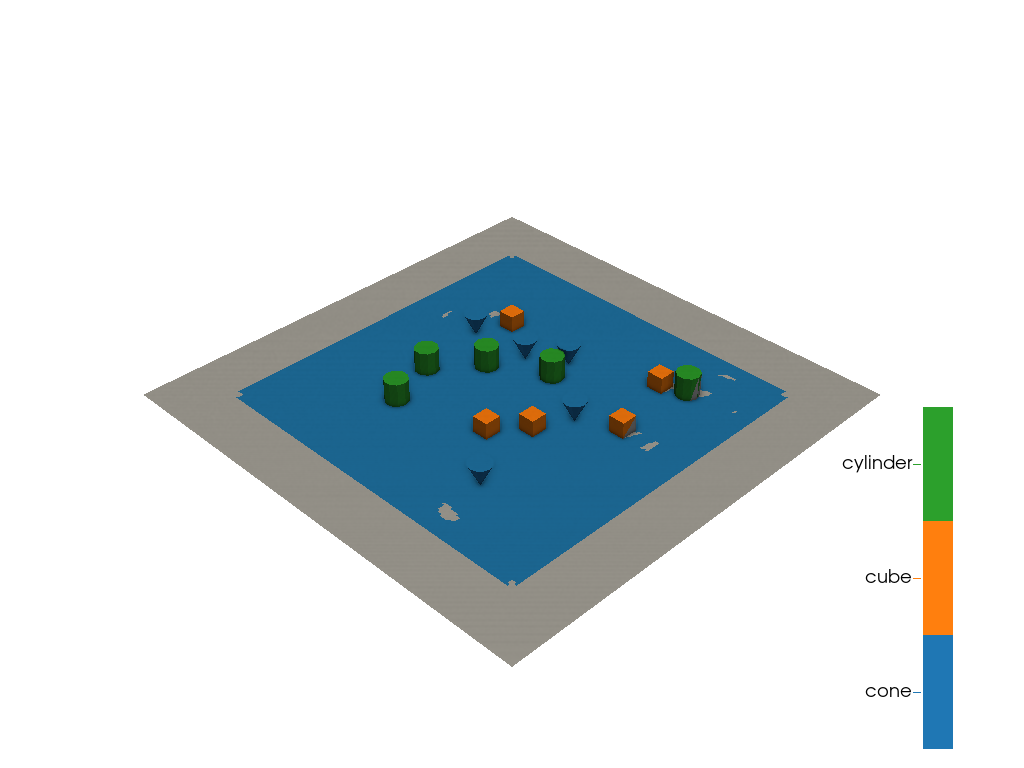

In [13]:
(
    averaged_projection, additional_information
) = aggregation_mesh.aggregate_projected_images(segmentor_camera_set)

max_class = np.argmax(averaged_projection, axis=1).astype(float)
zeros_mask = additional_information["projection_counts"]  == 0
max_class[zeros_mask] = np.nan
aggregation_mesh.vis(
    vis_scalars=max_class,
    force_xvfb=True,
    screenshot_filename=Path(FIGURES_SAVE_FOLDER, "aggregated_predicted_scene.png"),
    frustum_scale=VIS_FRUSTUM_SCALE,
)